# Oral Machine learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
# classe des systèmes dynamiques

class Dynamical_system():
    def __init__(self, dim, F, T):
        self.dim = dim
        self.F = F
        self.T = T
        self.time_frame = np.arange(T)
        self.traj  = np.zeros((self.T,self.dim))

    def random_traj(self):
        self.traj[0,:] = np.random.uniform(-2,2,self.dim)
        for k in range(1,T):
            self.traj[k,:] = self.F(self.traj[k-1,:])
        return self.traj
    
    def compute_traj(self, x_0,K):
        self.traj=np.zeros((K,self.dim))
        self.traj[0,:] = x_0
        for k in range(1,K):
            self.traj[k,:] = self.F(self.traj[k-1,:])
        return self.traj

    def random_traj_step(self, N,encoding_dim):
        traj_step = torch.zeros(N,self.dim*2+encoding_dim)
        traj_step[:,:self.dim*2] = torch.randn(N,self.dim*2)
        for k in range(N):
            traj_step[k,self.dim:self.dim*2] = self.F(traj_step [k,:self.dim])
        return traj_step

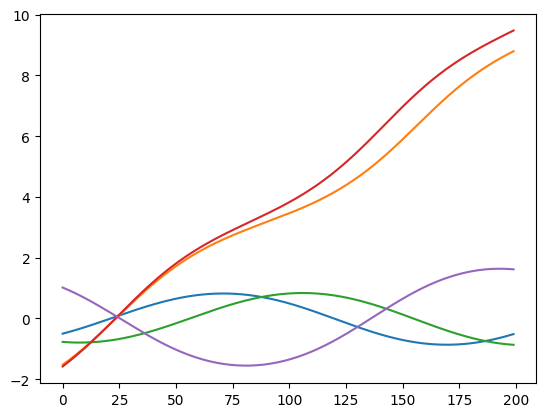

In [4]:
#test et training set

def F(x):
    dt = 1/30
    return torch.from_numpy(np.array([x[0]+x[1]*dt, x[1]-np.sin(x[0])*dt]))

#F = np.vectorize(F)
dim = 2
T =200

pendulum = Dynamical_system(dim,F,T)
#print(pendulum.traj)
for k in range(5):
    pendulum.random_traj()
    plt.plot(pendulum.time_frame, pendulum.traj.transpose()[0] )

In [4]:
#  deep Neural network

class Koopman(nn.Module):

    def __init__(self, dynamical_system, encoding_dim, hl_dim=30):
        super(Koopman, self).__init__()
        self.input_dim = dynamical_system.dim
        self.hl_dim = hl_dim
        self.encoding_dim = encoding_dim
        
        self.phi =nn.Sequential(
            nn.Linear(self.input_dim, self.hl_dim),
            nn.ReLU(),
            nn.Linear(self.hl_dim, self.encoding_dim),
            #nn.ReLU()
            )
        self.phi_inv = self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, self.hl_dim),
            nn.ReLU(),
            nn.Linear(self.hl_dim, self.input_dim),
            #nn.ReLU()
            )
        self.K = nn.Linear(self.encoding_dim, self.encoding_dim)

    def forward(self, traj_step):
        logits = torch.zeros([self.input_dim*2+self.encoding_dim], dtype=torch.double)
        #print("logit", logits)
        logits[:self.input_dim] = self.phi_inv(self.phi(traj_step[:self.input_dim]))
        #print(self.phi_inv(self.phi(traj_step[:self.input_dim])))
        
        logits[self.input_dim:self.input_dim*2] = self.phi_inv(self.K(self.phi(traj_step[:self.input_dim])))
        #print(self.phi_inv(self.K(self.phi(traj_step[:self.input_dim]))))
        
        logits[self.input_dim*2:] = self.K(self.phi(traj_step[:self.input_dim])) - self.phi(traj_step[self.input_dim:self.input_dim*2])
        #print(logits)
        return logits

In [5]:
def train(data,bs, model, loss_fn, optimizer):
    model.train()
    for k in range(bs):
        pred = model.forward(data[k,:])
        loss = loss_fn(pred, data[k,:])
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("last loss = ", loss)
    #l = test_encoder(model,loss_fn, N=20)
    #print("Encoder loss = ", l)
    #q = test_dynamic(model,loss_fn, data,N=20)
    #print("Dynamic loss = ", q)

In [6]:
def test(x_0,model,T):
    phi_traj = torch.zeros(T,model.encoding_dim)
    phi_traj[0,:] = model.phi(x_0)
    for k in range(T):
        phi_traj[k,:] = model.K(phi_traj[k-1,:])
    return model.phi_inv(phi_traj)

In [7]:
def test_encoder(model,loss_fn, N):
    test_set = torch.randn([model.input_dim,N], dtype = torch.double)
    pred = model.phi_inv(model.phi(test_set))
    l = loss_fn(pred,test_set)
    return l

In [8]:
def test_dynamic(model,loss_fn,data, N):
    test_set = data[:N,:]
    pred = model.phi_inv(model.K(model.phi(test_set[:,:model.input_dim])))
    l = loss_fn(pred,test_set)

### test \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

In [9]:
bs = 10000
encoding_dim = 10
traning_set = pendulum.random_traj_step(bs,encoding_dim)
#print(traning_set)

In [10]:

model = Koopman(pendulum, encoding_dim)
#loss_fn = nn.MSELoss()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
epochs = 30
for t in range(epochs):
    print("epoch = ",t)
    train(traning_set, bs, model, loss_fn, optimizer)
print("Done!")

epoch =  0
last loss =  tensor(0.1080, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  1
last loss =  tensor(0.1252, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  2
last loss =  tensor(0.1376, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  3
last loss =  tensor(0.1465, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  4
last loss =  tensor(0.1532, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  5
last loss =  tensor(0.1584, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  6
last loss =  tensor(0.1624, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  7
last loss =  tensor(0.1658, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  8
last loss =  tensor(0.1686, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  9
last loss =  tensor(0.1709, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  10
last loss =  tensor(0.1729, dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch =  11
last loss =  tensor(0.1746, dtype=torch.float64, gra

In [12]:
x_0 = torch.randn(2)
print(x_0)
J=20
traj_test = test(x_0,model,J)
traj_true = pendulum.compute_traj(x_0 ,J)
traj_autre = pendulum.compute_traj(traj_test.detach().numpy()[0,:],J)

tensor([0.5187, 1.8963])


In [13]:
#print("traj test = ",traj_test)
#print("traj test = ",traj_true)

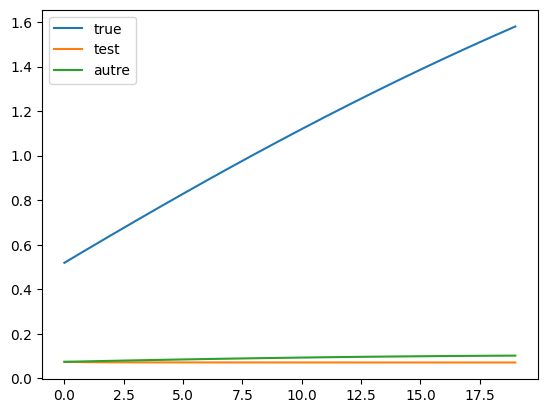

In [14]:
plt.plot(pendulum.time_frame[:J], traj_true.transpose()[0] ,label = 'true')
plt.plot(pendulum.time_frame[:J], traj_test.detach().numpy().transpose()[0], label='test')
plt.plot(pendulum.time_frame[:J], traj_autre.transpose()[0],label = 'autre')
plt.legend()
plt.show()

In [15]:
for k in range(10):
    x_0 = torch.randn(2)
    print(x_0)
    print(model.phi_inv(model.phi(x_0)))

tensor([0.5039, 0.8377])
tensor([0.0708, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([-0.2419,  0.9976])
tensor([0.0708, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([0.0694, 0.5729])
tensor([0.0708, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([ 0.9991, -0.8337])
tensor([0.0707, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([ 1.7140, -0.0223])
tensor([0.0707, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([ 0.8234, -0.8287])
tensor([0.0707, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([ 1.0713, -0.3048])
tensor([0.0707, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([1.1754, 0.3425])
tensor([0.0708, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([-1.2885, -0.3074])
tensor([0.0708, 0.0662], grad_fn=<SigmoidBackward0>)
tensor([ 0.0699, -0.0083])
tensor([0.0708, 0.0662], grad_fn=<SigmoidBackward0>)
